In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana
from scipy.interpolate import CubicSpline

In [2]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)


def folding_freq(fs, ps, sampling_time, makeplots=False):
    """
    ##bugs:
    - assumes fs are ordered
    - global delta_f
    """
    fc_guess = 1. / sampling_time
    
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fs, ps, extrapolate=False)
    
    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = get_started(1,fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]
    
    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color = 'red', alpha = 0.5)
        plt.title(fc)
        plt.show()

    
    return fc


In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_time= np.median(np.diff(lc.time.value))

In [5]:
f_max = (2 / (sampling_time))
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

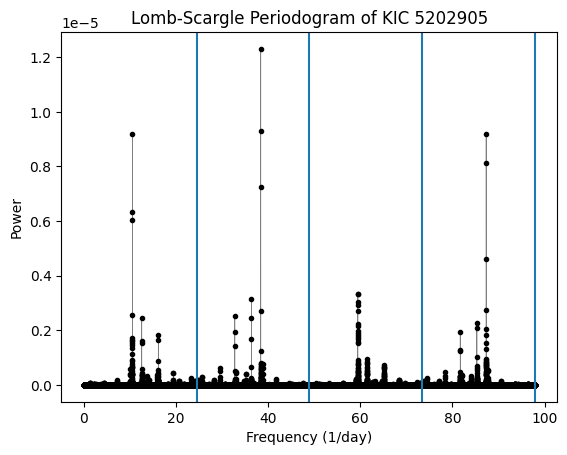

In [39]:
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.plot(freq, power,'k-', lw = 0.5, alpha = 0.5)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(1/sampling_time)
plt.axvline(1/(2*sampling_time))
plt.axvline(3/(2*sampling_time))
plt.show() 


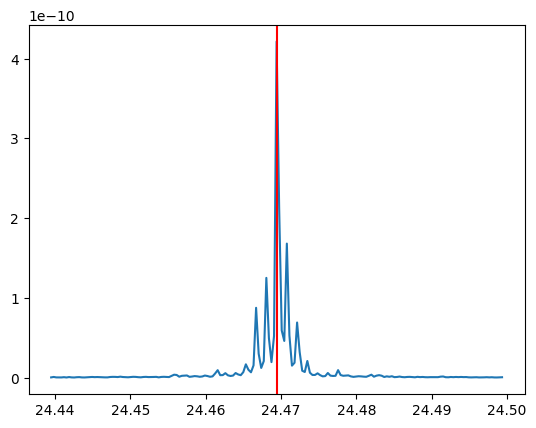

In [7]:
#Finding symmetry region A and B (freqB)
cs = CubicSpline(freq, power, extrapolate=False)
tiny, small = 0.5 * delta_f, 0.03
fb_approx = 1/(2*sampling_time)
fb_candidates = np.arange(fb_approx - small, fb_approx+small, tiny)
foosb = np.array([np.nansum(power * cs(2*fb_candidate - freq)) for fb_candidate in fb_candidates])
plt.plot(fb_candidates, foosb)
plt.axvline(fb_approx, color="red")


In [8]:
#find and refine freqb
fb_index = get_started(1,fb_candidates, foosb)
freqB, powerB, second_derivB = refine_peaks(fb_candidates, foosb, fb_index)
print(freqB)
print(fb_approx)

[24.46946992]
24.469500173919045


[48.93906267]
48.93900034783809


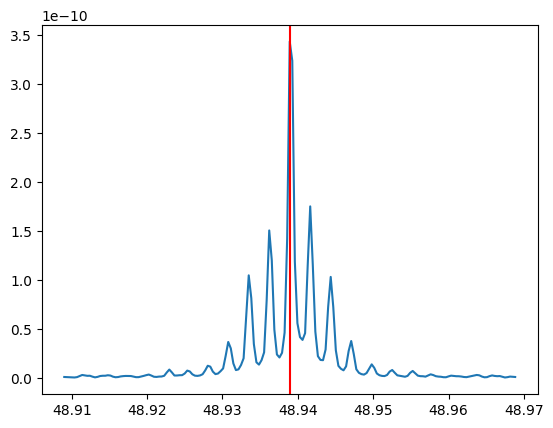

In [9]:
##Finding shift region A and C (freqC)
fc_approx = 1/sampling_time
fc_candidates = np.arange(fc_approx - small, fc_approx+small, tiny)
foos_c = np.array([np.nansum(power * cs(fc_candidate + freq)) for fc_candidate in fc_candidates])
plt.plot(fc_candidates, foos_c)
plt.axvline(fc_approx, color="red")

#find and refine freqc
fc_index = get_started(1,fc_candidates, foos_c)
freqC, powerC, second_derivC = refine_peaks(fc_candidates, foos_c, fc_index)
print(freqC)
print(fc_approx)

[73.40867095]
73.40850052175713


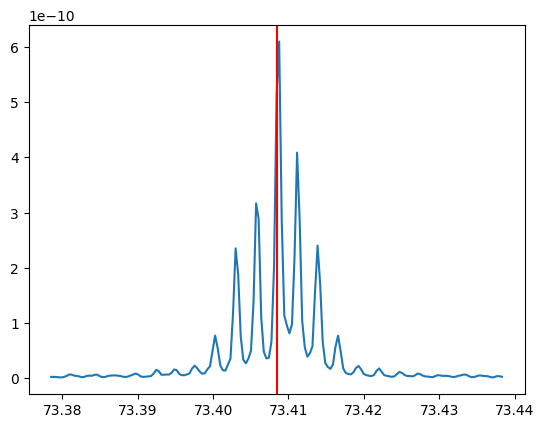

In [10]:
#Finding symmetry region A and D (freqD)
fd_approx = 3/(2*sampling_time)
fd_candidates = np.arange(fd_approx - small, fd_approx+small, tiny)

#am i allowed to use freqB like this???? this seems iffy
foosd = np.array([np.nansum(power * cs((fd_candidate + freqB) - freq)) for fd_candidate in fd_candidates])
plt.plot(fd_candidates, foosd)
plt.axvline(fd_approx, color="red")

#find and refine freqd
fd_index = get_started(1,fd_candidates, foosd)
freqd, powerd, second_derivd = refine_peaks(fd_candidates, foosd, fd_index)
print(freqd)
print(fd_approx)

[48.93905484]
48.93900034783809


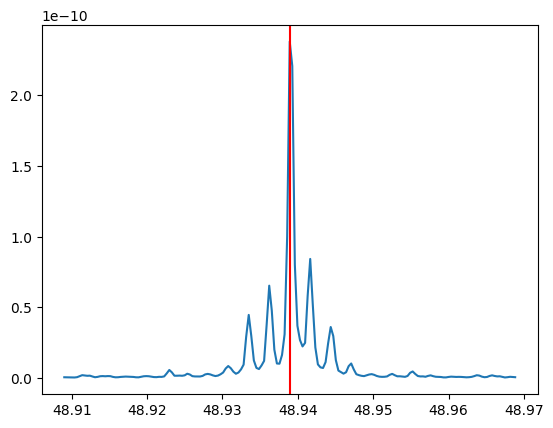

In [18]:
def folding_freqs(fs, ps, fc_guess):
    """
    ##bugs:
    - assumes fs are ordered
    """
    IA = fs < (0.5*fc_guess)
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fsA, psA, extrapolate=False)
    fc_candidates = np.arange(fc_guess - small, fc_guess+small, tiny)
    foos_c = np.array([np.nansum(power * cs(fc_candidate - freq)) for fc_candidate in fc_candidates])
    return (fc_candidates, foos_c)
    
#freqC
fsC, foosC = folding_freqs(freq, power, 1/sampling_time)
plt.plot(fsC, foosC)
plt.axvline(1/sampling_time, color="red")
fc_index = get_started(1,fsC, foosC)
freqC, powerC, second_derivC = refine_peaks(fsC, foosC, fc_index)
print(freqC)
print(1/sampling_time)

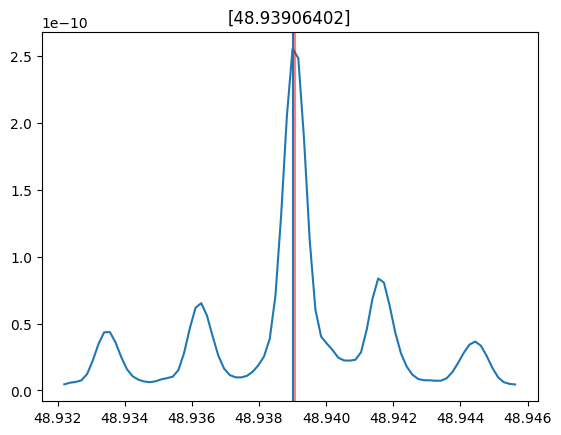

In [68]:
def folding_freq(fs, ps, sampling_time, makeplots=False):
    """
    ##bugs:
    - assumes fs are ordered
    - global delta_f
    """
    fc_guess = 1. / sampling_time
    
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fs, ps, extrapolate=False)
    
    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = get_started(1,fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]
    
    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color = 'red', alpha = 0.5)
        plt.title(fc)
        plt.show()

    
    return fc
    
    

fc = folding_freq(freq, power, sampling_time)




[24.46947023]
24.469500173919045


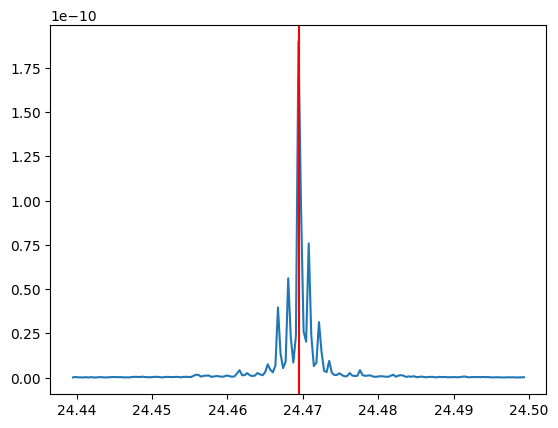

In [31]:
#freqB
fB_guess = 1/(2*sampling_time)
csB = folding_freqs(freq, power, 1/(2*sampling_time))
fb_candidates = np.arange(fB_guess - small, fB_guess+small, tiny)
foosb = np.array([np.nansum(power * csB(2*fb_candidate - freq)) for fb_candidate in fb_candidates])
plt.plot(fb_candidates, foosb)
plt.axvline(1/(2*sampling_time), color="red")

fb_index = get_started(1,fb_candidates, foosb)
freqB, powerB, second_derivB = refine_peaks(fb_candidates, foosb, fb_index)
print(freqB)
print(fB_guess)

[73.40866488]
73.40850052175713


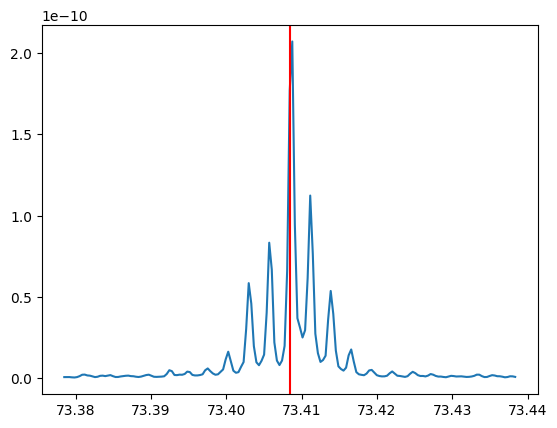

In [47]:
#freqD
fD_guess = 3/(2*sampling_time)
csD = folding_freqs(freq, power, fD_guess)
fd_candidates = np.arange(fd_approx - small, fd_approx+small, tiny)
#idk what to put into csD, does csD((fd_candidate + freqB) - freq)) work? 

foosd = np.array([np.nansum(power * csD((fd_candidate + freqB) - freq)) for fd_candidate in fd_candidates])
plt.plot(fd_candidates, foosd)
plt.axvline(fD_guess, color="red")

fd_index = get_started(1,fd_candidates, foosd)
freqd, powerd, second_derivd = refine_peaks(fd_candidates, foosd, fd_index)
print(freqd)
print(fD_guess)